# Preparing the environment

## Graphics and plotting

The following block of code initializes the Python plotting library [matplotlib](http://matplotlib.org/gallery.html) and configures it to show figures embedded in the notebook (as opposed to opening a new window for each figure):

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

The Seaborn library provides easy-to-use plotting functions for common plot types, and better default visual styles.

In [2]:
import seaborn as sea

Set the default size and style of the plot.  (Plots are styled to [look like R's `ggplot`](http://tonysyu.github.io/mpltools/auto_examples/style/plot_ggplot.html) library.)

In [3]:
matplotlib.rcParams['figure.figsize'] = (10, 7)

sea.set_style('dark')

Also make the NumPy library available (without it, some features of Matplotlib and -especially- Seaborn) will *not* work:

In [4]:
import numpy as np

## SQL database connection

The ESC403 cluster comes preinstalled with [Catherine Devlin's `%sql`-magic for IPython][1]; this allows you to run SQL queries from the IPython notebook, and intermix them with Python code.

[1]: https://github.com/catherinedevlin/ipython-sql

Before we can use the `%sql` syntax, two steps must be taken:

* Load the IPython-SQL bridge code

In [5]:
%load_ext sql

* Connect to an actual database; this must be the first `%sql` statement (the `rmurri@/equidistantpoints` syntax means "connect to the PostGreSQL DB named `equidistantpoints` running on *this* host as user `rmurri`" -- of course change `rmurri` to *your* user name):

In [6]:
%sql postgresql://chrble@/equidistantpoints

u'Connected: chrble@equidistantpoints'

This database contains the [Equidistant Geographic Grid Points and Modern Climate](http://mypage.iu.edu/~pdpolly/Data.html) dataset (this the "extended North American data" in the words of the source website), see the [original publication](http://mypage.iu.edu/~pdpolly/Data.html) for details.

We are going to use only the "temperature" table in the following. (But feel free to experiment with the others!)

In [7]:
%sql select * from natempwilmott limit 3;

3 rows affected.


id,longitude,latitude,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec,ann
6,-79.46900,82.81348,-35.00000,-37.00000,-33.00000,-24.90000,-10.00000,0.30000,3.30000,1.40000,-9.00000,-20.70000,-28.80000,-32.50000,-18.90000
7,-75.87860,82.81348,-35.00000,-37.10000,-32.80000,-24.70000,-9.90000,0.10000,3.30000,1.40000,-9.20000,-20.90000,-28.80000,-32.30000,-18.80000
8,-72.28820,82.81348,-34.90000,-36.90000,-32.70000,-24.60000,-9.90000,-0.10000,3.20000,1.30000,-9.50000,-20.90000,-28.80000,-32.00000,-18.80000


----

# Interactive plotting

Jupyter/IPython provides facilities for making interactive visualizations in the notebook.

The general schema for making an interactive visualization is:

1. Make a function that takes the interactively-settable parameters as arguments, and returns a "plot" (or any other object that can be shown in the notebook).
2. Decorate this function with the `@interact` annotation, providing initial values for all interactively-settable parameters.

All relevant code lives in Python module `ipywidgets`:

In [46]:
from ipywidgets import *

The following example shows how to create an interactive sine wave plot (see [here](http://earthpy.org/pyncview_pm.html)).  Note how IPython automatically detects the parameter type and uses a slider to set floating-point values and a text-box for the `color` parameter:

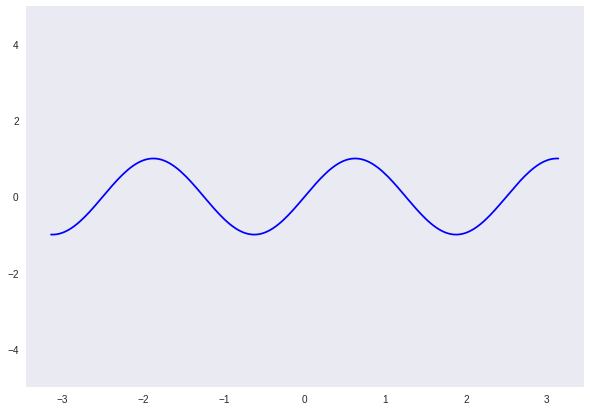

In [8]:
@interact(freq=1.0, amp=1.0, color='blue')
def wave(freq, amp, color):
    xs = np.linspace(-np.pi, +np.pi, 200)
    ys = np.sin(2*np.pi*freq*xs) * amp
    ax = plt.gca()
    ax.plot(xs, ys, color=color)
    ax.set_ylim([-5., +5.])
    return ax

However, with auto-detection we cannot constrain the input values: e.g., we cannot set the valid range of inputs, nor restrict the color selection.  It is possible to explicitly instanciate the widget to use for setting a parameter from a [large Widget list](http://ipywidgets.readthedocs.io/en/stable/examples/Widget%20List.html).

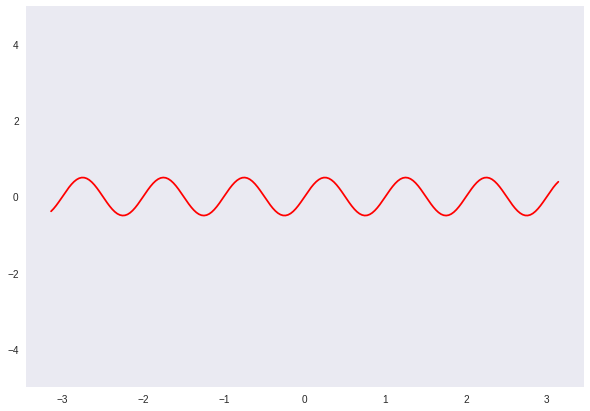

In [10]:
@interact(freq=1.0, 
          amp=FloatSlider(min=0.5, max=5.0, step=0.1), 
          color=Select(options=['red', 'green', 'blue'], description='color'))
def wave(freq, amp, color):
    xs = np.linspace(-np.pi, +np.pi, 200)
    ys = np.sin(2*np.pi*freq*xs) * amp
    ax = plt.gca()
    ax.plot(xs, ys, color=color)
    ax.set_ylim([-5., +5.])
    return ax

Using slider widgets often results in screen flickering (redrawing the plot is slower than just moving a slide).  The `continuous_update=False` argument can be added to the slider to only re-paint upon mouse button release.

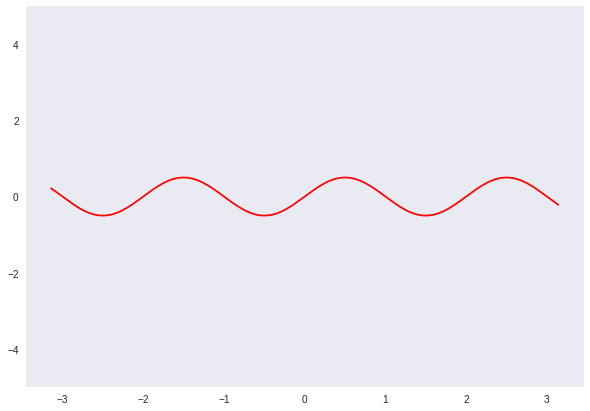

In [14]:
@interact(freq=FloatSlider(min=0.5, max=5.0, step=0.1, continuous_update=False), 
          amp=FloatSlider(min=0.5, max=5.0, step=0.1, continuous_update=False), 
          color=Select(options=['red', 'green', 'blue'], description='color'))
def wave(freq, amp, color):
    xs = np.linspace(-np.pi, +np.pi, 200)
    ys = np.sin(2*np.pi*freq*xs) * amp
    ax = plt.gca()
    ax.plot(xs, ys, color=color)
    ax.set_ylim([-5., +5.])
    return ax

----

## 1. Make an interactive plot of the earth surface: viewport is selected using sliders

In [40]:
import cartopy
import cartopy.crs
# Create a Cartopy crs for plain  lat-lon projections.
plain_crs = cartopy.crs.PlateCarree()

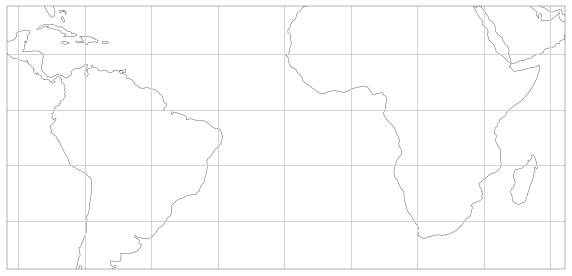

In [63]:
@interact(lonl=IntSlider(min=-180, max=180, step=1, continuous_update=False,description='longitude left'), \
          lonr=IntSlider(min=-180, max=180, step=1, continuous_update=False,description='longitude right' ),\
          latu=IntSlider(min=-90, max=90, step=1, continuous_update=False,description='latitude up'),\
          latd=IntSlider(min=-90, max=90, step=1, continuous_update=False,description='latitude down')\
         )
def make_map(lonl,lonr,latu,latd):
    ax = plt.subplot(111, projection=plain_crs)
    ax.set_extent((lonl, lonr, latu, latd), crs=plain_crs)
    ax.gridlines(color='lightgrey', linestyle='-')
    ax.coastlines()

## 2. Make an interactive plot of average temperatures in NA: month should be selectable

In [51]:
temps= %sql SELECT * FROM natempwilmott LIMIT 100;

100 rows affected.


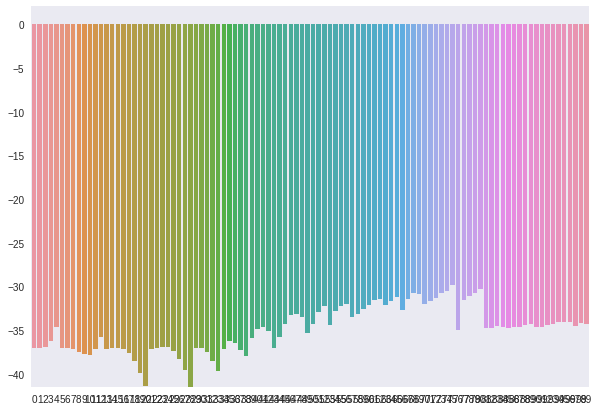

In [50]:
@interact(month=IntSlider(min=1, max=12,step=1,continuous_update=False), color='blue')
def get_average_temp(month):
    month_temps= [row[month+2] for row in temps]
    sea.barplot(np.array(range(len(month_temps))),np.array([float(t) for t in month_temps]))